#Crawling Data

In [2]:
!pip install selenium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.2/499.2 kB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 2.9 MB/s eta 0:00:00
  Attempting uninstall: typing_extensions
    Found existing installation: typing_extensions 4.14.0
    Uninstalling typing_extensions-4.14.0:
      Successfully uninstalled typing_extensions-4.14.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 r

In [6]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
import pandas as pd
import time

def crawl_bencana_bps(tahun_list):
    # Konfigurasi Chrome headless
    options = Options()
    options.add_argument("--headless")
    options.add_argument("--disable-gpu")
    options.add_argument("--no-sandbox")

    service = Service()
    driver = webdriver.Chrome(service=service, options=options)

    base_url = "https://www.bps.go.id/id/statistics-table/3/TUZaMGVteFVjSEJ4T1RCMlIyRjRTazVvVDJocVFUMDkjMw==/jumlah-bencana-alam-menurut-provinsi-dan-jenis-bencana-alam--kejadian---2023.html?year="

    for tahun in tahun_list:
        print(f"Memproses tahun {tahun}...")
        url = base_url + str(tahun)

        try:
            driver.get(url)
            time.sleep(5)
            html = driver.page_source
            tables = pd.read_html(html)

            if tables:
                df = tables[0]
                filename = f"data_bencana_alam_{tahun}.csv"
                df.to_csv(filename, index=False)
                print(f"Data tahun {tahun} berhasil disimpan ke '{filename}'")
            else:
                print(f"Tidak ada tabel ditemukan untuk tahun {tahun}")
        except Exception as e:
            print(f"Terjadi kesalahan saat memproses tahun {tahun}: {e}")

    driver.quit()

# Daftar tahun yang ingin dicrawl
tahun_list = [2021, 2022, 2023]
crawl_bencana_bps(tahun_list)

Memproses tahun 2021...
Data tahun 2021 berhasil disimpan ke 'data_bencana_alam_2021.csv'
Memproses tahun 2022...
Data tahun 2022 berhasil disimpan ke 'data_bencana_alam_2022.csv'
Memproses tahun 2023...
Data tahun 2023 berhasil disimpan ke 'data_bencana_alam_2023.csv'


#Pipeline

In [7]:
import pandas as pd
import numpy as np

# Fungsi pembersihan data bencana
def bersihkan_data_bencana(file_path):
    df = pd.read_csv(file_path)
    df_cleaned = df.copy()

    # Ganti value tidak valid dan nilai kosong
    df_cleaned.replace({"...": 0, "-": 0}, inplace=True)
    df_cleaned.fillna(0, inplace=True)

    # Ganti nama kolom
    rename_columns = {
        "Provinsi": "provinsi",
        "Jumlah Bencana Alam - Gempa Bumi": "gempa_bumi",
        "Jumlah Bencana Alam - Tsunami": "tsunami",
        "Jumlah Bencana Alam - Gempa Bumi dan Tsunami": "gempa_tsunami",
        "Jumlah Bencana Alam - Letusan Gunung Api": "letusan_gunung",
        "Jumlah Bencana Alam - Tanah Longsor": "tanah_longsor",
        "Jumlah Bencana Alam - Banjir": "banjir",
        "Jumlah Bencana Alam - Kekeringan": "kekeringan",
        "Jumlah Bencana Alam - Kebakaran Hutan dan Lahan": "karhutla",
        "Jumlah Bencana Alam - Cuaca Ekstrem": "cuaca_ekstrem",
        "Jumlah Bencana Alam - Gelombang Pasang/Abrasi": "gelombang_pasang"
    }
    df_cleaned.rename(columns=rename_columns, inplace=True)

    # Konversi ke numerik
    for col in df_cleaned.columns:
        if col != "provinsi":
            df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors="coerce").fillna(0).astype(int)

    # Hapus baris total "Indonesia"
    df_cleaned = df_cleaned[df_cleaned["provinsi"].str.strip().str.lower() != "indonesia"]

    # Reset index
    df_cleaned.reset_index(drop=True, inplace=True)

    return df_cleaned

# Daftar file dan nama output
file_paths = {
    "2021": "/content/data_bencana_alam_2021.csv",
    "2022": "/content/data_bencana_alam_2022.csv",
    "2023": "/content/data_bencana_alam_2023.csv"
}

# Proses masing-masing file dan simpan sebagai variabel berbeda
df_cleaned_2021 = bersihkan_data_bencana(file_paths["2021"])
df_cleaned_2022 = bersihkan_data_bencana(file_paths["2022"])
df_cleaned_2023 = bersihkan_data_bencana(file_paths["2023"])

# Tampilkan hasil
print("Data 2021:")
display(df_cleaned_2021)

print("Data 2022:")
display(df_cleaned_2022)

print("Data 2023:")
display(df_cleaned_2023)

Data 2021:


,provinsi,gempa_bumi,tsunami,gempa_tsunami,letusan_gunung,tanah_longsor,banjir,kekeringan,karhutla,cuaca_ekstrem,gelombang_pasang
0,Aceh,0,0,0,0,11,100,0,77,91,0
1,Sumatera Utara,0,0,0,0,23,83,0,13,54,0
2,Sumatera Barat,1,0,0,0,18,58,1,16,118,0
3,Riau,0,0,0,0,7,67,0,44,24,6
4,Jambi,0,0,0,0,11,37,0,24,24,3
5,Sumatera Selatan,0,0,0,0,4,39,0,24,24,1
6,Bengkulu,0,0,0,0,9,25,0,0,11,0
7,Lampung,0,0,0,0,5,25,0,0,46,0
8,Kepulauan Bangka Belitung,0,0,0,0,2,15,0,10,13,0
9,Kepulauan Riau,0,0,0,0,5,14,0,79,6,3


Data 2022:


,provinsi,gempa_bumi,tsunami,gempa_tsunami,letusan_gunung,tanah_longsor,banjir,kekeringan,karhutla,cuaca_ekstrem,gelombang_pasang
0,Aceh,0,0,0,0,9,110,0,51,51,1
1,Sumatera Utara,2,0,0,0,6,71,0,0,28,0
2,Sumatera Barat,4,0,0,0,7,24,0,8,34,1
3,Riau,0,0,0,0,6,41,0,34,11,4
4,Jambi,0,0,0,0,0,4,0,4,1,0
5,Sumatera Selatan,0,0,0,0,9,37,0,31,26,0
6,Bengkulu,0,0,0,0,2,36,0,0,6,0
7,Lampung,0,0,0,0,7,36,0,0,27,0
8,Kepulauan Bangka Belitung,0,0,0,0,0,6,0,13,27,1
9,Kepulauan Riau,0,0,0,0,0,3,0,1,7,0


Data 2023:


,provinsi,gempa_bumi,tsunami,gempa_tsunami,letusan_gunung,tanah_longsor,banjir,kekeringan,karhutla,cuaca_ekstrem,gelombang_pasang
0,Aceh,0,0,0,0,9,97,1,77,51,1
1,Sumatera Utara,1,0,0,0,19,112,0,41,44,0
2,Sumatera Barat,1,0,0,1,14,72,1,14,33,0
3,Riau,1,0,0,0,3,79,0,168,8,1
4,Jambi,0,0,0,0,4,24,0,56,8,1
5,Sumatera Selatan,0,0,0,0,3,28,1,29,24,0
6,Bengkulu,1,0,0,0,6,11,2,11,7,0
7,Lampung,0,0,0,0,3,19,1,28,23,0
8,Kepulauan Bangka Belitung,0,0,0,0,1,12,1,89,22,0
9,Kepulauan Riau,0,0,0,0,2,11,1,71,17,3


#Merge Data

In [5]:
def gabungkan_data_bencana(df_list, tahun_list):

    df_bersih = []

    for df, tahun in zip(df_list, tahun_list):
        # Tambah kolom Tahun
        df["tahun"] = tahun

        # Susun ulang kolom
        kolom_lain = [col for col in df.columns if col not in ["tahun", "provinsi"]]
        df = df[["tahun", "provinsi"] + kolom_lain]

        df_bersih.append(df)

    # Gabung semua DataFrame
    df_gabungan = pd.concat(df_bersih, ignore_index=True)

    return df_gabungan


df_gabungan = gabungkan_data_bencana(
    [df_cleaned_2021, df_cleaned_2022, df_cleaned_2023],
    [2021, 2022, 2023]
)

display(df_gabungan)

nama_file_csv = "data_bencana_gabungan.csv"
df_gabungan.to_csv(nama_file_csv, index=False)

print(f"\nData gabungan telah berhasil disimpan ke '{nama_file_csv}'")

,tahun,provinsi,gempa_bumi,tsunami,gempa_tsunami,letusan_gunung,tanah_longsor,banjir,kekeringan,karhutla,cuaca_ekstrem,gelombang_pasang
0,2021,Aceh,0,0,0,0,11,100,0,77,91,0
1,2021,Sumatera Utara,0,0,0,0,23,83,0,13,54,0
2,2021,Sumatera Barat,1,0,0,0,18,58,1,16,118,0
3,2021,Riau,0,0,0,0,7,67,0,44,24,6
4,2021,Jambi,0,0,0,0,11,37,0,24,24,3
...,...,...,...,...,...,...,...,...,...,...,...,...
101,2023,Papua Barat Daya,0,0,0,0,0,5,0,0,0,0
102,2023,Papua,2,0,0,0,2,4,0,0,0,3
103,2023,Papua Selatan,0,0,0,0,0,2,0,0,0,0
104,2023,Papua Tengah,0,0,0,0,0,0,1,0,0,0



Data gabungan telah berhasil disimpan ke 'data_bencana_gabungan.csv'


#Simpan ke Postgre (Aiven)

In [9]:
from sqlalchemy import create_engine

# Koneksi Aiven
db_user = 'avnadmin'
db_password = 'AVNS_bnDdPV1czlfPDL9dqq6'
db_host = 'dataenginservice-richonov-b85d.d.aivencloud.com'
db_port = '17745'
db_name = 'defaultdb'

# Format URL koneksi SQLAlchemy
DATABASE_URL = f'postgresql+psycopg2://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}'

# Buat engine koneksi
engine = create_engine(DATABASE_URL)

In [ ]:
df_gabungan.to_sql(
    name='data_bencana',
    con=engine,
    if_exists='replace',
    index=False
)

106

In [10]:
df_data = pd.read_sql('SELECT * FROM data_bencana', engine)
df_data.head(5)

,tahun,provinsi,gempa_bumi,tsunami,gempa_tsunami,letusan_gunung,tanah_longsor,banjir,kekeringan,karhutla,cuaca_ekstrem,gelombang_pasang
0,2021,Aceh,0,0,0,0,11,100,0,77,91,0
1,2021,Sumatera Utara,0,0,0,0,23,83,0,13,54,0
2,2021,Sumatera Barat,1,0,0,0,18,58,1,16,118,0
3,2021,Riau,0,0,0,0,7,67,0,44,24,6
4,2021,Jambi,0,0,0,0,11,37,0,24,24,3


#Machine Learning

In [6]:
!pip install pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 3.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of category-encoders to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.1/486.1 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 93.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/1

In [1]:
# Import Library
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from pycaret.classification import *
from sklearn.metrics import classification_report

In [2]:
# 1. Baca file CSV gabungan
df = pd.read_csv("data_bencana_gabungan.csv")

# 2. Tambahkan kolom total bencana
kolom_bencana = [
    'gempa_bumi', 'tsunami', 'gempa_tsunami', 'letusan_gunung',
    'tanah_longsor', 'banjir', 'kekeringan', 'karhutla',
    'cuaca_ekstrem', 'gelombang_pasang'
]
df['total_bencana'] = df[kolom_bencana].sum(axis=1)

# 3. Buat target klasifikasi: Rawan (Ya/Tidak)
df['rawan'] = df['total_bencana'].apply(lambda x: "Ya" if x >= 20 else "Tidak")

# 4. Inisialisasi PyCaret untuk klasifikasi
clf_setup = setup(
    data=df,
    target="rawan",
    ignore_features=["provinsi", "tahun", "total_bencana"],
    session_id=123
)

# 5. Bandingkan model dan pilih yang terbaik
best_model = compare_models()

,Description,Value
0,Session id,123
1,Target,rawan
2,Target type,Binary
3,Target mapping,"Tidak: 0, Ya: 1"
4,Original data shape,"(106, 14)"
5,Transformed data shape,"(106, 11)"
6,Transformed train set shape,"(74, 11)"
7,Transformed test set shape,"(32, 11)"
8,Ignore features,3
9,Numeric features,10


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.9857,1.0000,0.9857,0.9929,0.9874,0.9588,0.9645,0.0390
lr,Logistic Regression,0.9732,1.0000,0.9732,0.9694,0.9691,0.8588,0.8645,0.7870
ada,Ada Boost Classifier,0.9732,0.9500,0.9732,0.9694,0.9691,0.8588,0.8645,0.0980
xgboost,Extreme Gradient Boosting,0.9732,1.0000,0.9732,0.9694,0.9691,0.8588,0.8645,0.1490
rf,Random Forest Classifier,0.9607,1.0000,0.9607,0.9632,0.9582,0.8188,0.8300,0.1710
lightgbm,Light Gradient Boosting Machine,0.9589,1.0000,0.9589,0.9429,0.9482,0.7588,0.7645,0.1080
dt,Decision Tree Classifier,0.9464,0.8845,0.9464,0.9366,0.9373,0.7188,0.7300,0.0260
gbc,Gradient Boosting Classifier,0.9464,0.9345,0.9464,0.9366,0.9373,0.7188,0.7300,0.0840
et,Extra Trees Classifier,0.9446,0.9833,0.9446,0.8970,0.9190,0.6000,0.6000,0.1810
nb,Naive Bayes,0.9429,0.8333,0.9429,0.9184,0.9297,0.6833,0.6833,0.0250


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [3]:
# 6. Evaluasi model
evaluate_model(best_model)

# 7. Prediksi awal dan simpan model
prediksi = predict_model(best_model)
prediksi[['rawan', 'prediction_label', 'prediction_score']].head()

# 8. Simpan dan muat ulang model
save_model(best_model, 'model_rawan_bencana')
loaded_model = load_model('model_rawan_bencana')

# 9. Prediksi ulang untuk seluruh data
hasil_prediksi = predict_model(loaded_model, data=df)

# 10. Lihat hasil
print(hasil_prediksi[['provinsi', 'rawan', 'prediction_label', 'prediction_score']])

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,K Neighbors Classifier,0.9688,1.0000,0.9688,0.9750,0.9702,0.8710,0.8783


Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,K Neighbors Classifier,0.9811,1.0000,0.9811,0.9835,0.9817,0.9224,0.9252


             provinsi  rawan prediction_label  prediction_score
0                Aceh     Ya               Ya               1.0
1      Sumatera Utara     Ya               Ya               1.0
2      Sumatera Barat     Ya               Ya               1.0
3                Riau     Ya               Ya               1.0
4               Jambi     Ya               Ya               1.0
..                ...    ...              ...               ...
101  Papua Barat Daya  Tidak            Tidak               1.0
102             Papua  Tidak            Tidak               1.0
103     Papua Selatan  Tidak            Tidak               1.0
104      Papua Tengah  Tidak            Tidak               1.0
105  Papua Pegunungan  Tidak            Tidak               1.0

[106 rows x 4 columns]


              precision    recall  f1-score   support

       Tidak       0.88      1.00      0.93        14
          Ya       1.00      0.98      0.99        92

    accuracy                           0.98       106
   macro avg       0.94      0.99      0.96       106
weighted avg       0.98      0.98      0.98       106



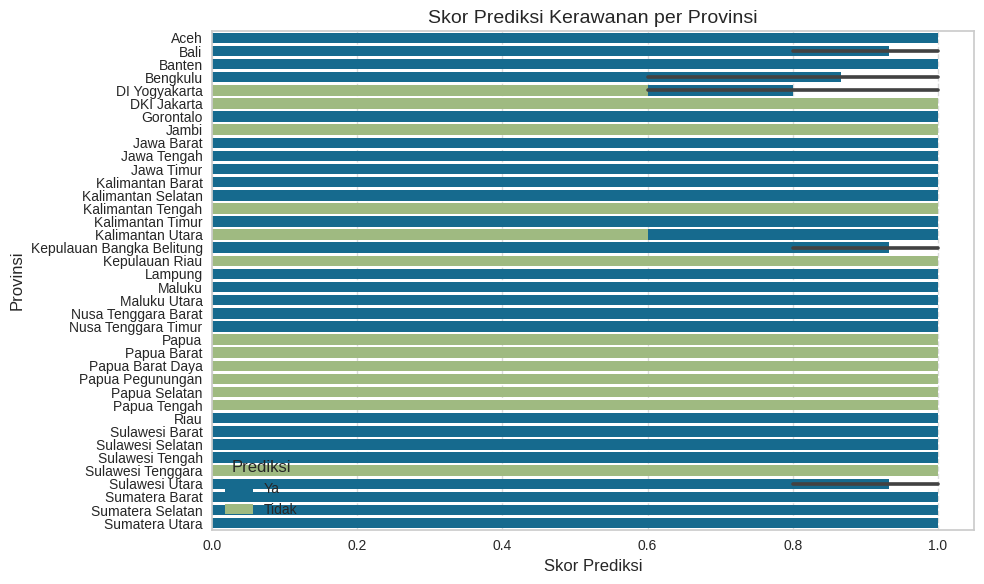

In [4]:
# 11. Laporan klasifikasi
print(classification_report(hasil_prediksi['rawan'], hasil_prediksi['prediction_label']))

# 12. Visualisasi hasil prediksi
sorted_pred = hasil_prediksi.sort_values('prediction_score', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=sorted_pred, x='prediction_score', y='provinsi', hue='prediction_label', dodge=False)
plt.title("Skor Prediksi Kerawanan per Provinsi", fontsize=14)
plt.xlabel("Skor Prediksi", fontsize=12)
plt.ylabel("Provinsi", fontsize=12)
plt.legend(title="Prediksi")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [5]:
# 13. Korelasi antar bencana
kolom_nomor = [
    'tahun', 'gempa_bumi', 'tsunami', 'gempa_tsunami', 'letusan_gunung',
    'tanah_longsor', 'banjir', 'kekeringan', 'karhutla',
    'cuaca_ekstrem', 'gelombang_pasang'
]
korelasi = df[kolom_nomor].corr()

# 14. Visualisasi Heatmap Korelasi
fig = px.imshow(
    korelasi,
    text_auto=True,
    color_continuous_scale='RdBu_r',
    aspect='auto',
    title="Heatmap Korelasi Jenis Bencana dan Tahun"
)
fig.update_layout(margin=dict(l=40, r=40, t=60, b=40))
fig.show()